# Chess Auto Encoder

- Use HalfKP

TODO:
- Fetch fens
- Convert to HalfKP
- Save to file

In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts

# set default plot size as large
plt.rcParams['figure.figsize'] = [20, 10]



# Create Dataset

## Fetch fens 

In [6]:
batch_size = 50
num_batch = 3000

FBP = get_FenBatchProvider(batch_size=batch_size)

def fetch_batch():
    fens = next(FBP)
    results = []
    for i, fen in enumerate(fens):
        d = {}
        d['fen'] = fen
        board = chess.Board(fen)
        pieces = dict(Counter([str(v) for v in board.piece_map().values()]))
        d = {**d, **pieces}

        results.append(d)
    return results


data = []
for i in tqdm(range(num_batch)):
    data = data  + fetch_batch()
print(f'Len data: {len(data)}')

df = pd.DataFrame(data).fillna(0)
del data
print(f'df shape: {df.shape}')

100%|██████████| 3000/3000 [00:11<00:00, 264.54it/s]


Len data: 150000
df shape: (150000, 13)


## Add concepts

In [7]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

(150000, 13)


150000it [05:07, 487.19it/s]

(150000, 29)


In [8]:
columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

In [9]:
# store df in sqlite db for later use
import sqlite3
conn = sqlite3.connect('chess_auto_encoder.db')
df.to_sql('fen_concept_df', conn, if_exists='replace', index=True)
conn.close()

del df


## Convert to HalfKP

# Dataset

# Autoencoder


# Custom Autoencoder

In [4]:
import matplotlib.pyplot as plt
from model import DeepAutoencoder
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

batch_size = 200
train_loader = get_FenBatchProvider(batch_size=batch_size)
val_loader = get_FenBatchProvider(batch_size=batch_size)


# Instantiating the model and hyperparameters
model = DeepAutoencoder(input_size=641)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
max_iterations = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model = model.cuda()

# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
  
# Training loop starts
for epoch in tqdm(range(num_epochs)):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    it = 0
    # Iterating over the training dataset
    for batch in train_loader:

        if it == max_iterations:
            break
        it += 1
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img = batch
        img = transform(img) 
        img = img.reshape(-1, model.input_size).cuda()
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img.int())
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)

    writer.add_scalar("Loss/train", running_loss, epoch)

    # save model every 100 epochs
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'./models/model_{epoch}.pt')
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
writer.flush()
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

# save model to disk
torch.save(model.state_dict(), 'model.pt')


 13%|█▎        | 126/1000 [34:44<4:00:57, 16.54s/it]


KeyboardInterrupt: 

In [1]:
a = 4

# Fetch activations from encoders

In [6]:
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
from small_model import DeepAutoencoder
from scipy.special import expit

# load model from disk

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('models/model_BCE_small_900.pt'))

# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()

activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
#model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
#model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
#model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
#model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

activation_list = []

for idx, row in tqdm(df.iterrows()):

    data = transform([row['fen']]).cuda()
    output = model(data)

    activations_ = {'index': idx}
    for k, v in activation.items():
        values = v.cpu().numpy()[0]
        if 0:
            if k in ['input_encoder_0',]:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values, dtype=bool)
            elif k in ['decoder_3']:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values > 0, dtype=bool)
            else:
                # convert values to numpy float16
                values = values.astype(np.float16)
        if k in ['decoder_3']:
            values = expit(values)
        else:
            values = values.astype(np.float16)
        
        activations_[k] = values


    # copy activation and add to activation_list
    activation_list.append(activations_.copy())

df_activations = pd.DataFrame(activation_list)
df_activations.head()

150000it [01:20, 1857.14it/s]


,index,input_encoder_0,encoder_0,encoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.18, -3.123, -4.426, -4.566, -4.31, -2.686,...","[-4.62, 4.6, 2.79, 15.914, -1.982, -2.559, 5.1...","[6.508, 1.433, -52.7, -38.16, -38.25, -12.59, ...","[7.55385e-21, 1.8392207e-20, 2.3199758e-22, 1...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.63, -3.096, -5.6, -4.703, -3.246, -1.735, ...","[-7.598, 0.609, -0.2153, 5.29, -9.86, -3.184, ...","[12.05, 10.93, -36.12, -36.56, -29.67, 3.033, ...","[1.4449236e-24, 4.4216033e-25, 4.4893125e-26, ..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.066, -2.17, -6.2, -4.164, -3.432, -2.014, ...","[-18.94, 3.182, 2.537, 11.49, -2.59, 0.2343, 4...","[0.7256, 4.98, -35.34, -37.5, -25.62, 5.58, -3...","[2.7595757e-20, 2.179792e-20, 4.4423396e-21, 5..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.775, -1.37, -4.523, -3.41, -4.156, -1.383,...","[5.34, 1.092, -11.47, -10.125, -0.466, 5.734, ...","[10.21, -34.06, -37.0, -33.8, -25.62, 10.49, -...","[1.5042852e-22, 2.2871306e-21, 9.459297e-22, 2..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.67, -0.6133, -1.974, -2.314, -2.18, -0.874...","[-0.597, 3.434, 1.5205, -2.152, 10.56, 3.992, ...","[17.22, -14.41, -38.8, -25.06, -25.89, -11.04,...","[5.825696e-17, 1.9044598e-17, 1.09265556e-16, ..."


# Concept Model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1

test_size = 0.33
input_name = 'encoder_3'
target_name = 'has_contested_open_file'

concept_model = LGBMClassifier()
#concept_model = LogisticRegression()
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [RidgeClassifier(), LGBMClassifier()]
input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    #'encoder_2', 
    #'encoder_3', 
    #'decoder_0', 
    #'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]
target_names = [
    'has_contested_open_file',
    'white_double_pawn', 
    'white_queen'
    ]


results = []
for concept_model in concept_models:
    for input_name in input_names:
        for target_name in target_names:

            model_name = f"{concept_model.__class__.__name__}"

            X = df_activations[input_name].tolist()
            y = df[target_name].tolist()
            print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

            # if X is scipy.sparse.csr_matrix, vstack it 
            if isinstance(X[0], csr_matrix):
                X = vstack(X).astype(np.float32)
                size = X.shape[1]
            else:
                size = len(X[0])

            # change type of y to int
            y = np.array(y).astype(int)

            if target_name == 'white_queen':
                # is y larger than 0
                y = y > 0

            # fit and apply the transform
            X, y = undersample.fit_resample(X, y)


            # split into train and test sets 
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )



            concept_model.fit(X_train, list(y_train))
            y_pred = concept_model.predict(X_test)

            score = metric(y_test, y_pred)

            # calculate confusion matrix
            matrix = confusion_matrix(y_test, y_pred)

            if verbose:
                print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                print(f'input shape: {size}')
                print(matrix)
                print(score)

            results_ = {'model_name': model_name,
                        'input_name': input_name, 
                        'target_name': target_name,
                        'score': score, 
                        'size': size}
            results.append(results_)

df_results = pd.DataFrame(results)
df_results

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: decoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: decoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: decoder_2, y: white_queen, model_name: .RidgeClassifier
X: decoder_3, y: has_contested_open_file, model_name: .RidgeClassifier
X: decoder_3, y: white_double_pawn, model_name: .RidgeClassifier
X: decoder_3, y: white_queen, model_name: .RidgeClassifier
X: inpu

,model_name,input_name,target_name,score,size
0,RidgeClassifier,input_encoder_0,has_contested_open_file,0.536537,641
1,RidgeClassifier,input_encoder_0,white_double_pawn,0.502291,641
2,RidgeClassifier,input_encoder_0,white_queen,1.000000,641
3,RidgeClassifier,encoder_0,has_contested_open_file,0.524525,1024
4,RidgeClassifier,encoder_0,white_double_pawn,0.512712,1024
5,RidgeClassifier,encoder_0,white_queen,1.000000,1024
6,RidgeClassifier,encoder_1,has_contested_open_file,0.257257,8
7,RidgeClassifier,encoder_1,white_double_pawn,0.148324,8
8,RidgeClassifier,encoder_1,white_queen,0.575076,8
9,RidgeClassifier,decoder_2,has_contested_open_file,0.259927,1024


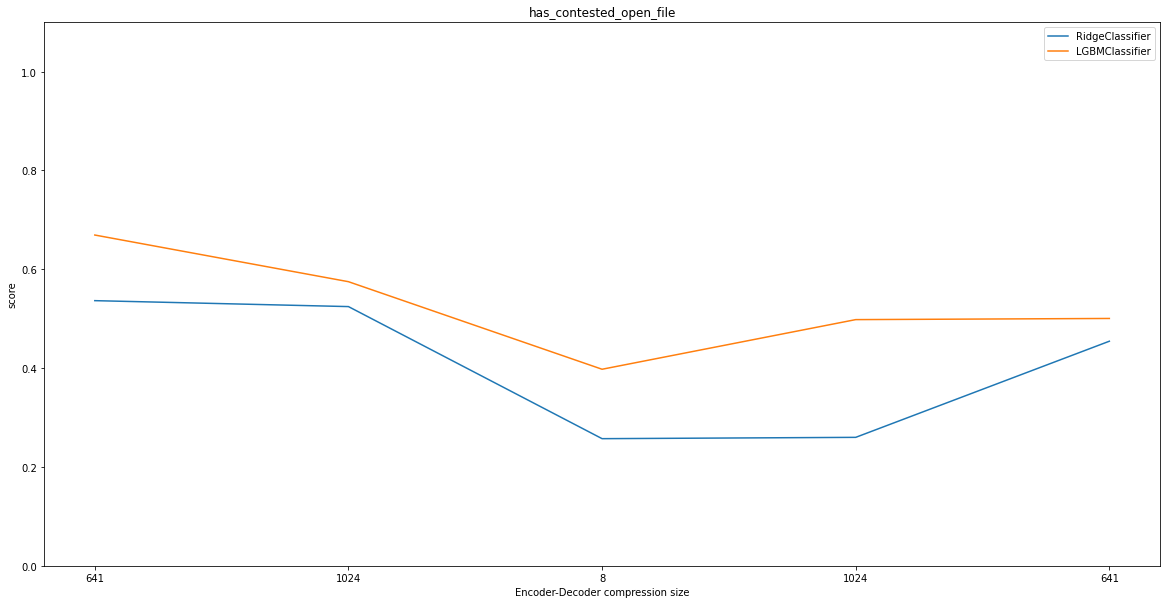

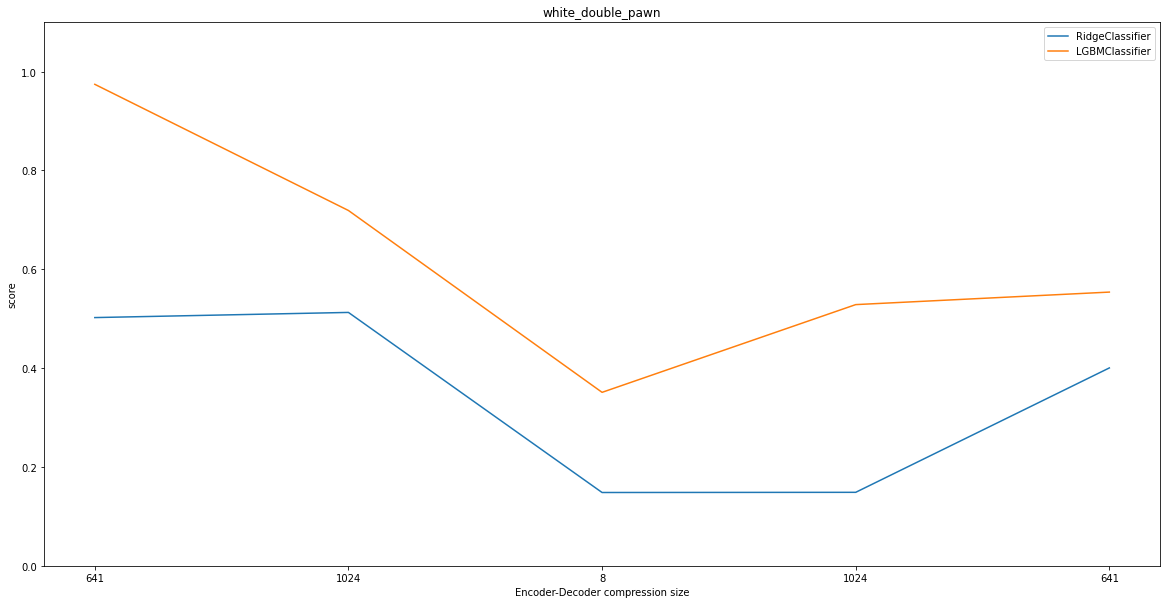

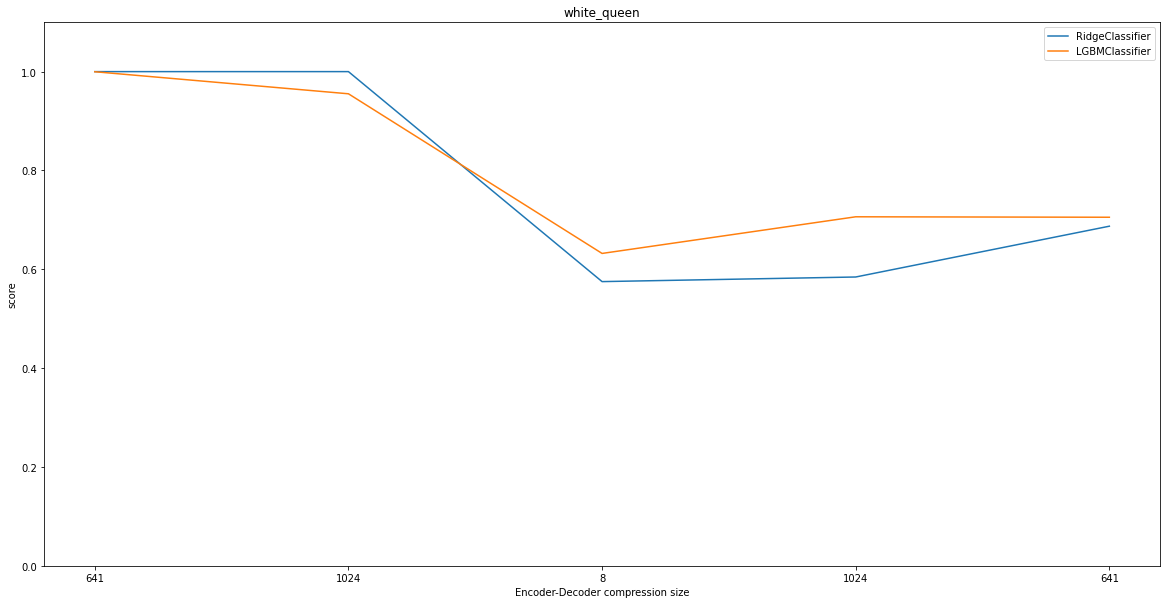

In [4]:
for target_name in df_results.target_name.unique():
    df_results_ = df_results[df_results.target_name == target_name]
    for model_name  in df_results_.model_name.unique():
        # plot scores
        plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

    # set x ticks as size   
    plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
    plt.title(target_name)
    plt.ylabel('score')
    plt.xlabel('Encoder-Decoder compression size')
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()

# 

In [9]:
torch.sigmoid(torch.tensor(00))

tensor(0.5000)